<style>
text.js-plot-link-container { 
    display: none; 
}
</style>

## Heatmap

This notebook demonstrates a part of code to process Geodata, using such libraries as H3, Folium and Shapely.

A business goal is to produce a heatmap with comparison of taxi fixed airport transfers prices vs base city tariff from/to different city locations to/from airport.

In [41]:
def prices_heatmap(data, airport, values_field, direction=None, is_new_prices=False):
    """
    Function to visualise the heatmap with the prices from Airport to hexagon
        data: DataFrame or dict with DataFrames.
        airport: Airport name, to filter data and show on heatmap.
        values_field: field with values for heatmap.
        direction: 'from' or 'to' the airport.
        is_new_prices: True if heatmap is for the new prices proposal.
    """
    
    if isinstance(data, pd.DataFrame):
        df = data[data.airport == airport]
    else:
        df = data[airport]
        
    if not is_new_prices:
        colorscale_min = -60
        colorscale_max = 60
        colorscale_caption = 'Fixed prices markup to city tariff (%)'
    else:
        colorscale_min = 1500
        colorscale_max = 4500
        colorscale_caption = 'Price by city tariff (RUB)'
        
    if values_field == 'price_tariff_rub_discounted':
        colorscale_caption = 'New price proposal (RUB)'

    if direction:
        heatmap_name = f'{airport} ({direction})'
    else:
        heatmap_name = airport
        
    print(heatmap_name)
    
    linear_colormap = cmp.LinearColormap(
        ['red', 'yellow', 'green'],
        vmin=colorscale_min, vmax=colorscale_max,
        caption=colorscale_caption
    )
    colorscale = linear_colormap

    def style_function(feature):
        return {
            'fillOpacity': 0.7,
            'weight': 0,
            'color': '#000000',
            'weight': 0.7,
            'fillColor': colorscale(df[df.hexagon_id_airport == feature.get('geometry').get('hexagon_id_airport')][values_field].values[0] if not is_new_prices \
                                    else df[df.okrug_name == feature.get('geometry').get('okrug_name')].price_tariff_rub_weighted.values[0]
                                   )
        }

    m = folium.Map(location=msc_center, zoom_start=9, width='55%'))

    for idx, row in df.iterrows():
        folium.GeoJson(row['geojson_polygon'],
                      tooltip=(row['hexagon_id'] + ': ' + str(row[values_field]) + '%') if not is_new_prices else (str(row[values_field]))
                      ,
                      style_function=style_function).add_to(m)
        folium.Marker(row['hex_center_lat_lon'] if not is_new_prices else list(row['polygon_center'].coords)[0][::-1]
                        , icon=folium.features.DivIcon(
                             html=f'<div style="font-size: 6pt; color : black">{str(row[values_field])}%</div>' if not is_new_prices else \
                                    f'<div style="font-size: 8pt; color : black">{str(row[values_field])}</div>'
                        )).add_to(m)

    # add airport on map
    airport_lat_lon = df_airports_info[df_airports_info.airport == airport].lat_lon.values[0]
    folium.Marker(airport_lat_lon,
                  tooltip=airport,
                  icon=folium.Icon(color='red', icon='plane')).add_to(m)

    # add title
    folium.Marker([56.011313, 37.847164], icon=folium.features.DivIcon(
                        icon_size=(100,36),
                        html='<div style="font-size: 14pt; color: black; background: white;"> ' + \
                                 f'{heatmap_name}' \
                             '</div>',
                        )).add_to(m)
    
    colorscale.add_to(m)

    return m

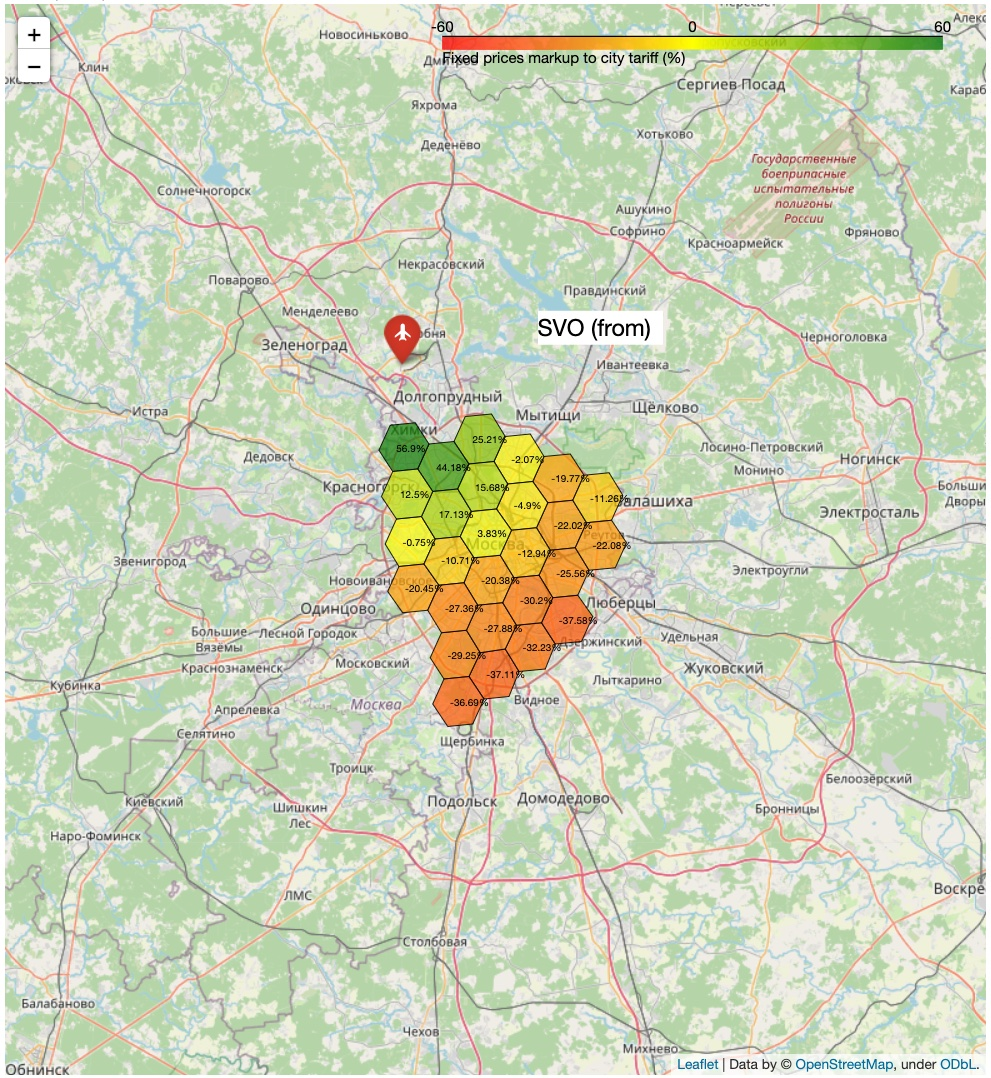

In [1]:
airport = 'SVO'
# airport = 'VKO'
# airport = 'DME'

# for direction in ['from', 'to']:
#     values_field = f'fixed_vs_tariff_{direction}_price_pct'
#     m = prices_heatmap(df_hexagons_vs_airports, airport, values_field, direction)
#     display(m)

## since Github doesn't display the heatmap with the commands above, use the image instead
from IPython.display import Image
Image(filename='svo_from.jpg') 